### Cargar Datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import BreakFinder as BF #Importar codigo, debe estar en la misma carpeta

In [2]:
def Open_b(dat,n): 
    '''
    Abrir en binario
    La lista debe tener el orden, no es indexado
     '''
    f = open(dat,'r')
    ndiskt = np.fromfile(f,'int32',1)
    Data = []
    for ii in range(n):
        row = np.fromfile(f,'double',ndiskt[0])
        Data.append(np.array(row))
    f.close()
    return Data


Aqui cargaré los datos de una galaxia en particular

In [3]:
h = 0.6777
galaxia = 1 # <===== Puedes cambiar 0,1,2 para ver otras galaxias
IDs = [228251,235404,239412] 
path = lambda f :'data/DATA_DISK_STAR_'+str(f)+'.dat'
galaxydat = Open_b(path(IDs[galaxia]),13)
rstars3D,mstars,ohstars,hzstars,agestars,rxstars,rystars,rzstars,epis,aexptemp,maxtemp,ofesstars,nostars = galaxydat
rstars = np.sqrt(rxstars**2 + rystars**2)
rstars = rstars*1e3 #kpc
cut=rstars>=2
rstars,mstars=rstars[cut],mstars[cut]

## Bin Movil
En el codigo añadi una funcion llamada SDBinMovil($r$,$m$,$n$), $r$ es la posicion radial proyectada, $m$ es la masa de cada particula estelar de esta galaxia, y $n$ es el numero de particulas por bin. El codigo arma un perfil de densidad superficial usando bines moviles. A diferencia del bineado normal, este metodo tiene la caracteristica que suaviza el perfil, lo que hace es ordenar la posicion las particulas de mayor a menor. Luego toma $2n$ particulas alrededor de la particula $n$th y calcula la densidad superficial, luego repite lo mismo a la particula $(n+1)$th y asi sucesivamente hasta $N-n$th, donde $N$ es el numero total de particulas. Vamos a probar tomando el 20\% de particulas por bin (10\% por lado).

Si te has dado cuenta, la primera particula que toma es $i=n$ y no $i=0$, esto es porque el bin movil toma una cantidad fija de particulas por bin, asi que hay que tener cuidado en elegir un $n$ muy grande porque pierdes de los bordes, y si elijes $n$ muy chicos tienes mucho ruido. Asi que si usas este metodo debes tener en cuenta en elegir un $n$ adecuado

5.9942618872730495 7.082952431014039


((24176,), 3021, (24176,), 30218)

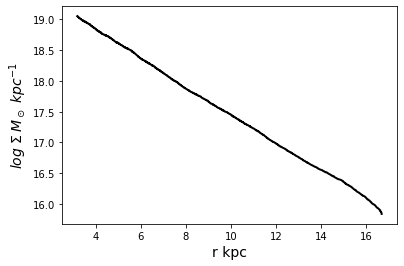

In [4]:
npart=len(rstars)
print(np.log10(mstars.min()), np.log10(mstars.max()))
bins,sigma = BF.SDBinMovil(rstars,mstars,int(npart*0.1))
plt.plot(bins,sigma,lw=2,c='k')
plt.ylabel('$log\; \Sigma\; M_\odot \;kpc^{-1}$',fontsize=14)
plt.xlabel('r kpc',fontsize=14)
bins.shape,int(npart*0.1), sigma.shape, npart

### Doble Exponencial 
Primero debes cargar el perfil en la clase breaks, y luego llamar a la funcion DoubleExp, esto te va a retornar un diccionario con todos los datos necesarios de la doble exponencial

Nota: en exp al final puse un tercer parametro, esta anclada a otra funcion de la clase pero por ahora no lo vamos a usar.
Nota2: Vamos a usar el perfil anterior que fue creado con bines moviles, pero igual puedes usar con bines fijos como vimos hoy en la reunion. 

In [5]:
exp = BF.breaks(bins,sigma,np.zeros_like(sigma))
Lib2exp = exp.DoubleExp()
Lib2exp.keys()

dict_keys(['h_i', 'h_o', 'I0i', 'I0o', 'Rbr', 'LineFit', 'LineFit_in', 'LineFit_out', 'ChiSquare', 'pcov'])

'h_i', 'h_o': inner and outer scalelenghts 

'I0i', 'I0o': inner and outer central intensities

'Rbr' :       Break Radius

'LineFit', 'LineFit_in', 'LineFit_out' : Perfil de ajuste Total, interno y externo 

'ChiSquare', 'pcov': Chi square, y covarianza que entrega curve_fit

Text(0.5, 0, 'r kpc')

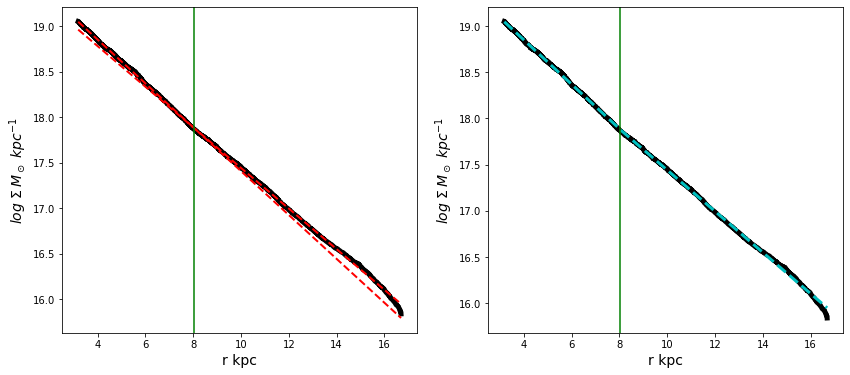

In [6]:
LineT = Lib2exp['LineFit']
Linein,Lineout = Lib2exp['LineFit_in'],Lib2exp['LineFit_out']

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(bins,sigma,lw=5,c='k')
#plt.plot(LineT[0],LineT[1],c='c',ls='--',lw=3)
plt.plot(Linein[0],Linein[1],c='r',ls='--',lw=2)
plt.plot(Lineout[0],Lineout[1],c='r',ls='--',lw=2)
plt.axvline(Lib2exp['Rbr'], c='g')
plt.ylabel('$log\; \Sigma\; M_\odot \;kpc^{-1}$',fontsize=14)
plt.xlabel('r kpc',fontsize=14)

plt.subplot(122)
plt.plot(bins,sigma,lw=5,c='k')
plt.plot(LineT[0],LineT[1],c='c',ls='--',lw=3)
#plt.plot(Linein[0],Linein[1],c='r',ls='--',lw=2)
plt.axvline(Lib2exp['Rbr'], c='g')
plt.ylabel('$log\; \Sigma\; M_\odot \;kpc^{-1}$',fontsize=14)
plt.xlabel('r kpc',fontsize=14)

In [7]:
beta = Lib2exp['h_i']-Lib2exp['h_o']
print('hi:',Lib2exp['h_i'],'\nho:',Lib2exp['h_o'],'\nbeta:',beta,'\nRbreak:',Lib2exp['Rbr'])

hi: 4.152614717538012 
ho: 4.485210937994847 
beta: -0.3325962204568347 
Rbreak: 8.027621689985112


### Exponencial simple
Aqui la funcion se llama PureExp()

In [8]:
Lib1exp = exp.PureExp()
Lib1exp.keys()

dict_keys(['h_i', 'I0', 'LineFit', 'ChiSquare', 'pcov'])

Su uso es muy similar al caso anterior, solo que aqui tienes menos parametros